# Model #2 Simple Linear Regression (Covid->Fuel)


* Import owid_covid_data.csv, fuel_prices_com.csv & GBP_USD.csv







# Imports

In [49]:
# Libraries
import pathlib
import numpy as np
import pandas as pd
# Graphs
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
# Modelling

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
# Checking for multicolinearity
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import linregress
# Modeling metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt



# Data Collection


In [50]:
# Importing covid_dataset using pandas. 
covid_dataset_data= pd.read_csv('owid_covid_data.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
covid_dataset = covid_dataset.loc[covid_dataset.location=='United States', ['date', 'total_cases', 'total_deaths']]
covid_dataset.head()
# covid_dataset = covid_dataset.dropna()  
# We do not want to drop empty tables as this is null values are part of our dataset


,date,total_cases,total_deaths
32403,2019-12-31,0.0,0.0
32404,2020-01-01,0.0,0.0
32405,2020-01-02,0.0,0.0
32406,2020-01-03,0.0,0.0
32407,2020-01-04,0.0,0.0


In [51]:
# Import forex
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
forex_dataset = forex_dataset.fillna(method='ffill')
forex_dataset = pd.DataFrame(forex_dataset,columns=['Price','Date'])


In [52]:
# Import fuel price
fuel_dataset = pd.read_csv('fuel_prices_com.csv', encoding= 'unicode_escape')
fuel_dataset = fuel_dataset.loc[fuel_dataset.Country=='USA', ['Date','Diesel', 'Brent oil price']]

In [53]:
print(covid_dataset.shape), print(forex_dataset.shape),print(fuel_dataset.shape)

(218, 3)
(214, 2)
(29, 3)


(None, None, None)

# Data Preprocessing / Data Cleaning & Collating


*   We first isolate the date column both fuel_dataset and forex_dataset so that they are formatted in the same way.  
*   Challenge: Fuel Price dataset is a weekly timeseries dataset whereas Forex Price is a daily timeseries dataset.




In [54]:
# We first convert the value to a string datetime 
fuel_dataset['Date'] = fuel_dataset['Date'].apply(lambda x: pd.to_datetime(str(x)))
fuel_dataset['Date'].head()


772   2020-06-01
773   2020-01-13
774   2020-01-20
775   2020-01-27
776   2020-03-02
Name: Date, dtype: datetime64[ns]

In [55]:
# We find out the format for where the day, month and year lie.
fuel_dataset["Date"] = pd.to_datetime(fuel_dataset["Date"], format="%d-%m-%Y")
forex_dataset["Date"] = pd.to_datetime(forex_dataset["Date"], format="%b %d, %Y")
# We transform these values to the same format.
fuel_dataset["Date"] = fuel_dataset["Date"].dt.strftime("%d-%m-%Y")
forex_dataset["Date"] = forex_dataset["Date"].dt.strftime("%d-%m-%Y")
# We then convert them back to a dataframe.
fuel_dataset["Date"] = pd.to_datetime(fuel_dataset["Date"], format="%d-%m-%Y")
forex_dataset["Date"] = pd.to_datetime(forex_dataset["Date"], format="%d-%m-%Y")

In [56]:
# We set the index for both datasets to be date.
forex_dataset.set_index("Date", inplace=True)
fuel_dataset.set_index("Date", inplace=True)
forex_dataset["Date"] = forex_dataset.index
fuel_dataset["date"] = fuel_dataset.index

In [57]:
# We then group these dates in a weekly period column
fuel_dataset["week"] = fuel_dataset.index.to_period('W')
forex_dataset["week"] = forex_dataset.index.to_period('W')

In [58]:
# We then join our datasets on the week column
data_ff = pd.merge(
    forex_dataset,
    fuel_dataset,
    left_on="week",
    right_on="week",
    how="left"
)

In [59]:
data_ff[data_ff.Diesel.isnull() | data_ff.Price.isnull()]
data_ff['Brent oil price'].isnull()

0      True
1      True
2      True
3      True
4      True
       ... 
230    True
231    True
232    True
233    True
234    True
Name: Brent oil price, Length: 235, dtype: bool

In [60]:
# We isolate the features that we want in our dataset
data_ff = pd.DataFrame(data_ff, columns = ['Date', 'Price', 'Diesel', 'Brent oil price']) 
# In order to merge with the next dataset we have to convert our Date frome from a datatime type to a string object.
data_ff['Date'] = data_ff['Date'].astype(str)

In [61]:
# We merge covid dataset with the forex + fuel dataset
data_ff = pd.merge(left=data_ff, left_on='Date',
         right=covid_dataset, right_on='date')

In [62]:
# Fill diesel with the mean 
data_ff = pd.DataFrame(data_ff, columns = ['Date', 'Price','total_deaths', 'total_cases','Diesel', 'Brent oil price']) 
data_ff['Diesel'].fillna((data_ff['Diesel'].mean()), inplace=True) # Notice how our dataset starts from the end rather than the top
data_ff['Brent oil price'].fillna((data_ff['Brent oil price'].mean()), inplace=True)
dataset = data_ff.iloc[::-1,:] # Reverse order of dataset
dataset.reset_index(drop=True, inplace=True) #Reset index

In [63]:
dataset = pd.DataFrame(dataset, columns = ['Date', 'total_deaths','Diesel']) 
dataset

,Date,total_deaths,Diesel
0,2019-12-31,0.0,0.69532
1,2020-01-01,0.0,0.69532
2,2020-01-02,0.0,0.69532
3,2020-01-03,0.0,0.69532
4,2020-01-04,0.0,0.69532
...,...,...,...
230,2020-07-27,146935.0,0.69532
231,2020-07-28,148011.0,0.69532
232,2020-07-29,149256.0,0.69532
233,2020-07-30,150713.0,0.69532


# Plotting Features before Normalisation

### Organising date for plotting

In [64]:
# Isolate date for plotting
date = dataset['Date']
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', '2020-07-31', periods=len(date))})
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()

### Plotting Diesel Prices

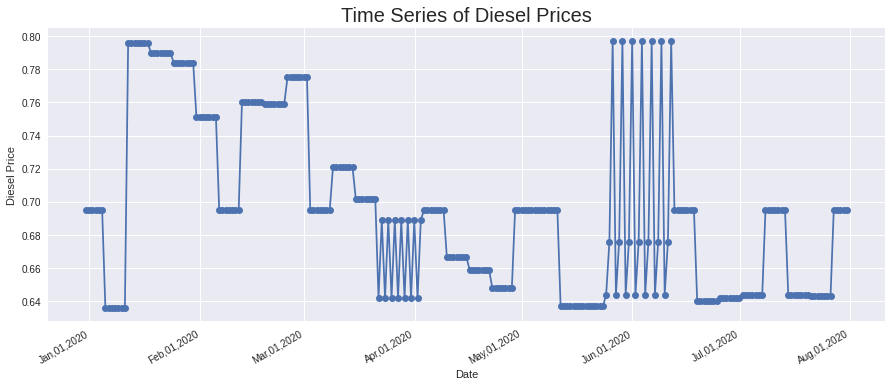

In [65]:
rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
diesel = np.array(dataset['Diesel'])
plt.plot_date(dates,diesel, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Diesel Prices', size = 20)
plt.xlabel('Date')
plt.ylabel('Diesel Price')
plt.gca().xaxis.set_major_formatter(date_format)

### Plotting Accumulative Covid Deaths

In [66]:
# Adds the accumulative deaths every day of a country
total_deaths = dataset['total_deaths']
newDayDeaths = 0
daily_total_deaths = []
for dailyDeaths in total_deaths:
  newDayDeaths = dailyDeaths + newDayDeaths
  daily_total_deaths.append(newDayDeaths)


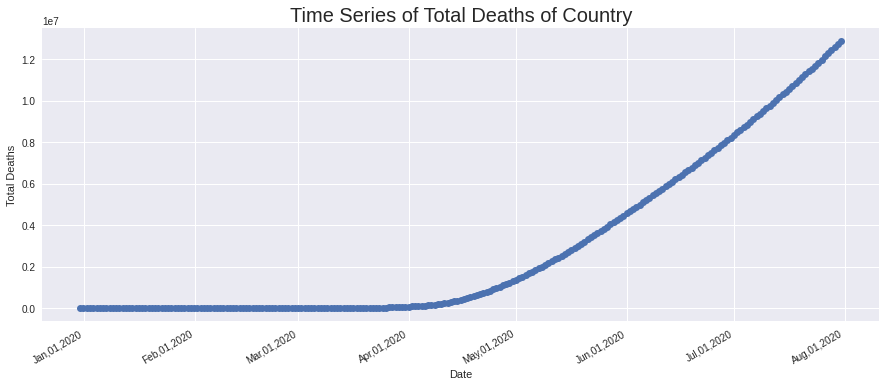

In [67]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
deaths = np.array(daily_total_deaths)
plt.plot_date(dates, deaths, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of Country', size = 20)
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(date_format)



# Plotting Features after Normalisation

In [68]:
death_frame = pd.DataFrame(np.concatenate([daily_total_deaths]), columns= ["Total_Deaths_US"])
diesel_frame = pd.DataFrame(np.concatenate([diesel]), columns= ["Diesel"])



In [69]:
scaler = MinMaxScaler(feature_range=(0,1))
normalisation_us_deaths = scaler.fit_transform(death_frame).reshape(-1,1)
normalisation_diesel_price = scaler.fit_transform(diesel_frame).reshape(-1,1)

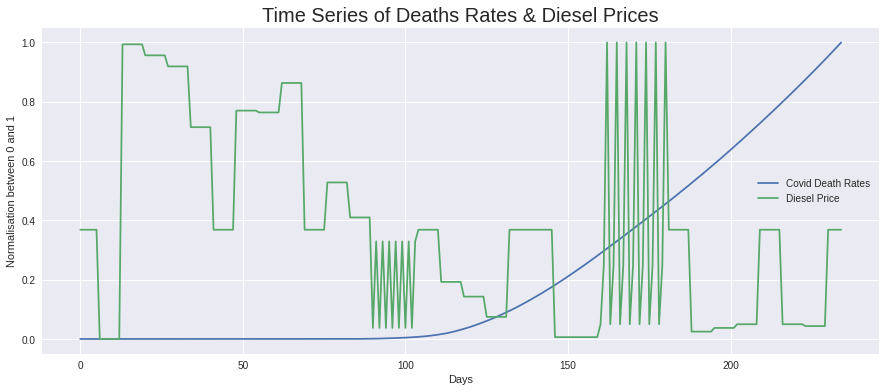

In [70]:
plt.plot(normalisation_us_deaths,label="Covid Death Rates")
plt.plot(normalisation_diesel_price, label="Diesel Price")
dates = np.array(dateFormatting['new_date'])
plt.title('Time Series of Deaths Rates & Diesel Prices', size = 20)
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Days')
plt.legend() 
plt.show()



### Creating dataset

In [71]:
new_dataset = np.hstack((normalisation_us_deaths, normalisation_diesel_price))
new_dataset = pd.DataFrame(new_dataset,columns=['total_deaths', 'Diesel'])
new_dataset.head()

,total_deaths,Diesel
0,0.0,0.368447
1,0.0,0.368447
2,0.0,0.368447
3,0.0,0.368447
4,0.0,0.368447


In [72]:
X = new_dataset[['total_deaths']]
Y = new_dataset['Diesel']

# Split triain & test

In [73]:
x_train, x_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=0, shuffle = False) 

# Modelling

In [74]:
def get_best_fit_train ():
  rcParams['figure.figsize'] = 15,6
  pred = model_lr.coef_ * x_train + model_lr.intercept_
  plt.plot(x_train, label = 'x_train')
  plt.plot(y_train, label = 'y_train')
  plt.plot(pred, label = 'y_pred', color = "red", linewidth=2)
  plt.xlabel('Covid-19 Deaths Input')
  plt.ylabel('Diesel Price Output')
  plt.legend()

def get_best_fit_test ():
  rcParams['figure.figsize'] = 15,6
  pred = model_lr.coef_ * x_test + model_lr.intercept_
  plt.plot(x_test, label = 'x_test')
  plt.plot(y_test, label = 'y_test')
  plt.plot(pred, label = 'y_pred', color = "red", linewidth=2)
  plt.xlabel('Covid-19 Deaths Input')
  plt.ylabel('Diesel Price Output')
  plt.legend()

# Performance Metric

In [88]:
def get_performance_train (model_pred):
  print('Mean Absolute Error:', mean_absolute_error(y_train, model_pred).round(4))  
  print('Mean Squared Error:', mean_squared_error(y_train, model_pred).round(4))
  print('R2_Score:',r2_score(y_train, model_pred).round(4)) 


In [89]:
def get_performance_test (model_pred):
  print('Mean Absolute Error:', mean_absolute_error(y_test, model_pred).round(4))  
  print('Mean Squared Error:', mean_squared_error(y_test, model_pred).round(4))  
  print('R2_Score:',r2_score(y_test, model_pred).round(4)) 


# Simple Linear Regression

In [77]:
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [78]:
pred_train_lr=model_lr.predict(x_train)
pred_test_lr=model_lr.predict(x_test)

Text(0.5, 1.0, 'Where Linear Regression Model Train Results Fall on Actual Diesel Price')

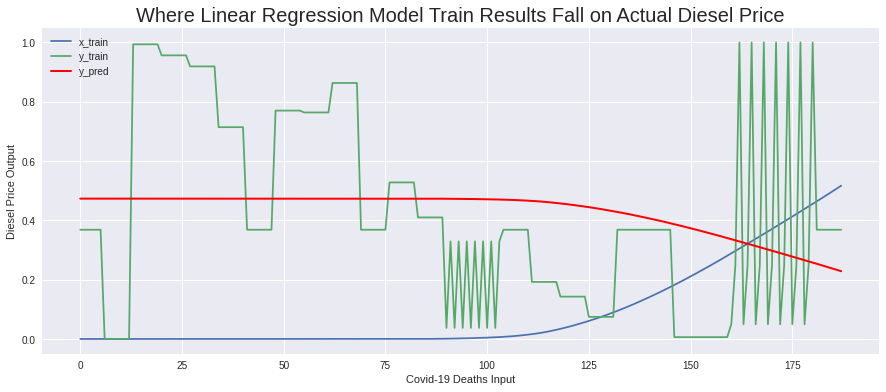

In [79]:
get_best_fit_train()
plt.title('Where Linear Regression Model Train Results Fall on Actual Diesel Price', size = 20)

Text(0.5, 1.0, 'Where Linear Regression Model Test Results Fall on Actual Diesel Price')

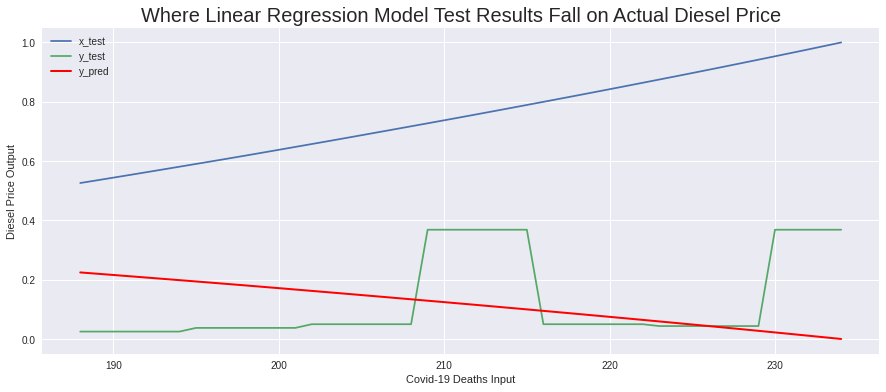

In [80]:
get_best_fit_test()
plt.title('Where Linear Regression Model Test Results Fall on Actual Diesel Price', size = 20)

# Comparison



## Performance Metrics

In [90]:
print('Train:')
get_performance_train(pred_train_lr)
print('\nTest:')
get_performance_test(pred_test_lr)


Train:
Mean Absolute Error: 0.2648
Mean Squared Error: 0.101
R2_Score: 0.0461

Test:
Mean Absolute Error: 0.1454
Mean Squared Error: 0.0331
R2_Score: -0.6184


## Visual Representation

### Train

In [82]:
comparison_train = pd.DataFrame({'Actual': y_train, 'Predicted': pred_train_lr})
comparison_train = comparison_train.head(7)
comparison_train.sort_index(inplace=True)
comparison_train

,Actual,Predicted
0,0.368447,0.473345
1,0.368447,0.473345
2,0.368447,0.473345
3,0.368447,0.473345
4,0.368447,0.473345
5,0.368447,0.473345
6,0.000000,0.473345


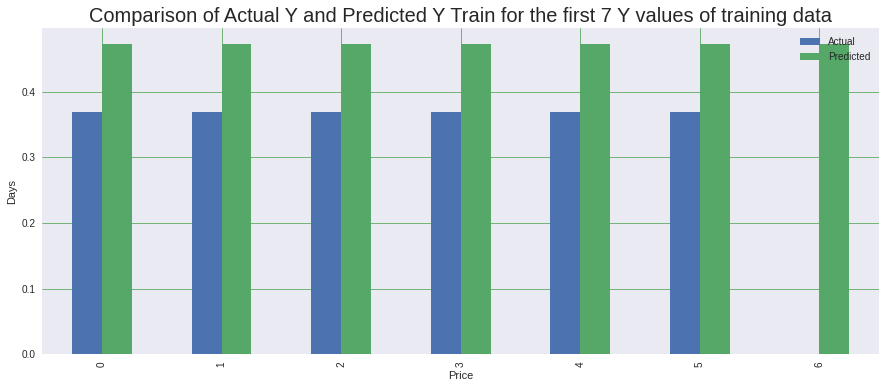

In [83]:
rcParams['figure.figsize'] = 15,6
comparison_train.plot(kind='bar')
plt.title('Comparison of Actual Y and Predicted Y Train for the first 7 Y values of training data', size=20)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Price')
plt.ylabel('Days')
plt.show()

### Test

In [84]:
comparison_test = pd.DataFrame({'Actual': y_test, 'Predicted': pred_test_lr})
comparison_test = comparison_test.tail(7)
comparison_test.sort_index(inplace=True)
comparison_test

,Actual,Predicted
228,0.043478,0.032768
229,0.043478,0.027380
230,0.368447,0.021974
231,0.368447,0.016528
232,0.368447,0.011037
233,0.368447,0.005492
234,0.368447,-0.000103


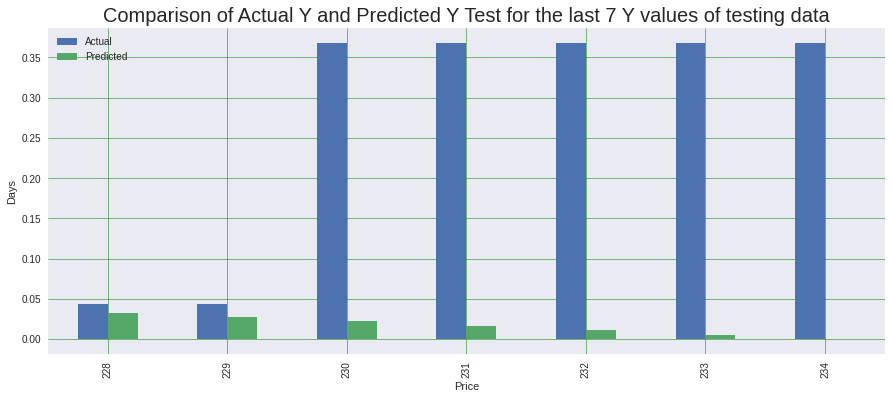

In [85]:
rcParams['figure.figsize'] = 15,6
comparison_test.plot(kind='bar')
plt.title('Comparison of Actual Y and Predicted Y Test for the last 7 Y values of testing data', size=20)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Price')
plt.ylabel('Days')
plt.show()

# Simple Linear Regression Formula

In [86]:
slope = model_lr.coef_[0]
intercept = model_lr.intercept_
print("formula: y = {0} + {1}x".format(intercept,slope))

formula: y = 0.4733449972150656 + -0.47344759022765426x
